# Test Audio Samples Plotting

In [15]:
import os
import torchaudio
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from fnmatch import fnmatch
from pathlib import Path
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram

from matplotlib.ticker import ScalarFormatter, LogLocator
%matplotlib inline

In [16]:
torchaudio.set_audio_backend("sox_io")

In [17]:
def check_dc_offset(pred, target):
    pred_offset = pred.mean()
    target_offset = target.mean()
    dc_offset = pred_offset - target_offset

    # Smallest quantization step for 16-bit audio
    quantization_step_16bit = 1 / 32767.0

    # Check if the absolute value of the DC offset is smaller or larger than the quantization step
    if abs(dc_offset) < quantization_step_16bit:
        print("The DC offset is smaller than the smallest quantization step for 16-bit audio.")
    else:
        print("The DC offset is larger than the smallest quantization step for 16-bit audio.")

In [18]:
def overlap_waveforms(o, t, sample_rate, start, end, title):    

    o_zoom = o[start:end]
    t_zoom = t[start:end]

    # create time vector
    time = range(start, end)

    plt.figure(figsize=(5,5))
    plt.plot(time, o_zoom, alpha=0.8, label="Model")
    plt.plot(time, t_zoom, alpha=0.8, label="Target")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"results/plots/{title}_waves.png")
    plt.show()

In [19]:
from matplotlib.ticker import ScalarFormatter
import numpy as np
from scipy.signal import spectrogram, get_window
import matplotlib.pyplot as plt

def target_output_spectra(o, t, sample_rate, start, end, title):

    o_zoom = o[start:end]
    t_zoom = t[start:end]

    N = len(o)                   # Number of sample points
    T = 1.0 / sample_rate        # sample spacing


    nfft = N
    seg = None 
    overlap = None
    # w = get_window('blackman', seg)
    w = None

    freq_o, times_o, Sxx_o = spectrogram(
        o_zoom, 
        fs=sample_rate, 
        nperseg=seg,
        noverlap=overlap,  
        scaling='spectrum', 
        mode='magnitude'
    )
    freq_t, times_t, Sxx_t = spectrogram(
        t_zoom, 
        fs=sample_rate, 
        nperseg=seg,
        noverlap=overlap,  
        scaling='spectrum', 
        mode='magnitude'
    )

    # Convert magnitude to dB
    o_Sxx_dB = 10 * np.log10(Sxx_o + 1e-10)
    t_Sxx_dB = 10 * np.log10(Sxx_t + 1e-10)

    average_o = np.mean(o_Sxx_dB, axis=1)
    average_t = np.mean(t_Sxx_dB, axis=1)

    plt.figure(figsize=(6, 4))

    plt.plot(freq_o, average_o, alpha=1, label="Model", linewidth=0.5)
    plt.plot(freq_t, average_t, alpha=1, label="Target", linewidth=0.5)

    plt.grid()
    plt.xscale('log')  # Frequency should often be plotted on a log scale
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Average Magnitude (dB)')
    plt.legend()
    
    # Use ScalarFormatter to avoid scientific notation
    ax = plt.gca()
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)
    plt.tight_layout()
    plt.show()


In [20]:
def process_directory(directory_path, start, end):
    """
    Walk through directory_path, and for each pair of out_{some_model_name}.wav and tgt_{same_model_name}.wav, 
    load them using torchaudio and call overlap_waveforms and two_spectrograms_difference functions.
    """
    directory_path = Path(directory_path)
    output_files = [f for f in directory_path.iterdir() if f.name.startswith("out_") and f.suffix == ".wav"]
    
    for out_file in output_files:
        # Extract the model name and sample rate by splitting on '_'. 
        # This assumes the format is consistent with what's shown.
        parts = out_file.stem.split("_")
        model_name = "_".join(parts[1:-1])  # Combine everything except 'out' and sample rate.
        sample_rate_suffix = parts[-1]
        
        # Construct the expected name for the tgt file
        tgt_file_name = f"tgt_{model_name}_{sample_rate_suffix}.wav"
        tgt_file = directory_path / tgt_file_name
        
        if tgt_file.exists():
            # Load the audio files using torchaudio
            output, sample_rate = torchaudio.load(out_file)
            target, _ = torchaudio.load(tgt_file)
            
            output = output.view(-1).numpy()
            target = target.view(-1).numpy()

            title = model_name + "_" + sample_rate_suffix
            
            # Call your functions
            overlap_waveforms(output, target, sample_rate, start, end, title)
            target_output_spectra(output, target, sample_rate, start, end, title)
        else:
            print(f"Matching target file for {out_file} not found!")

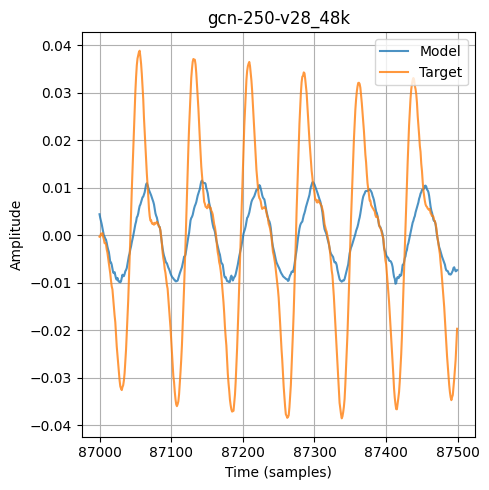

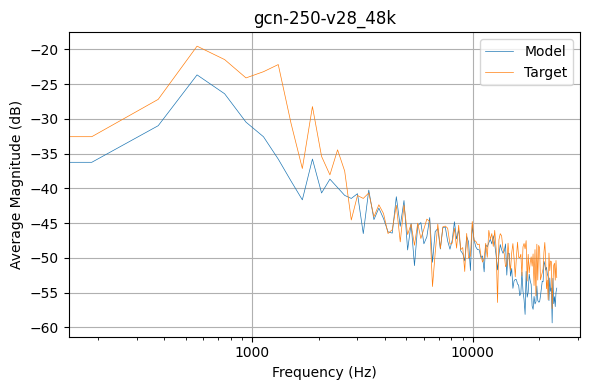

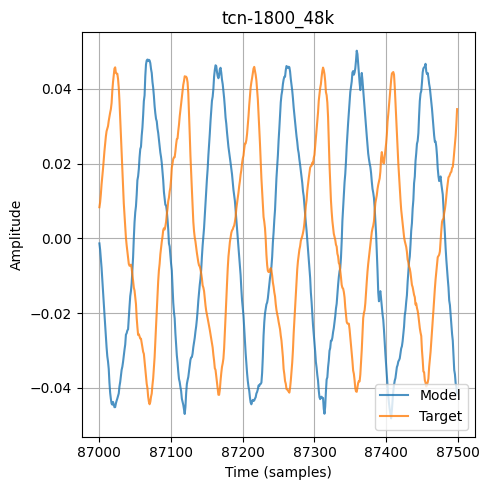

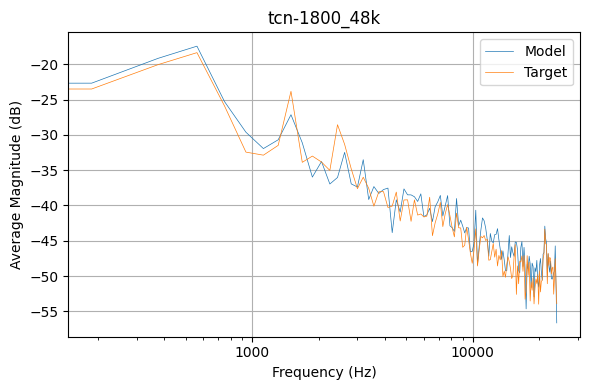

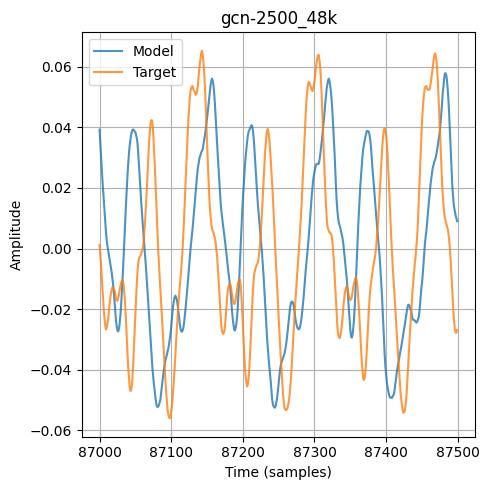

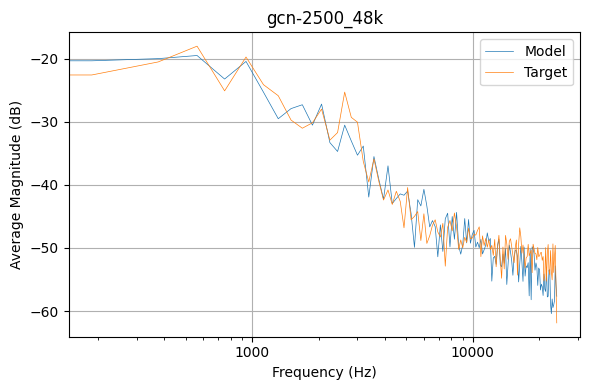

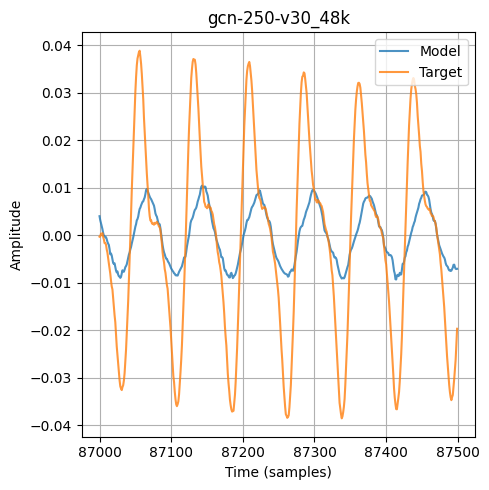

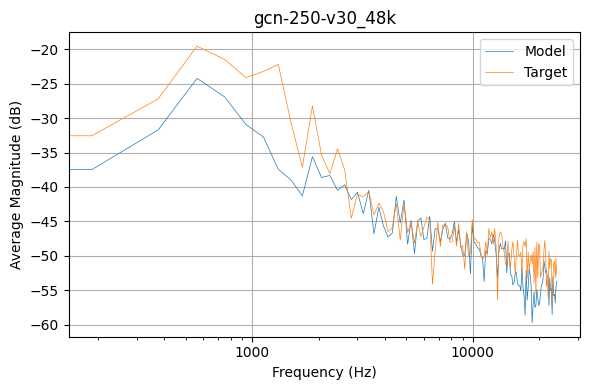

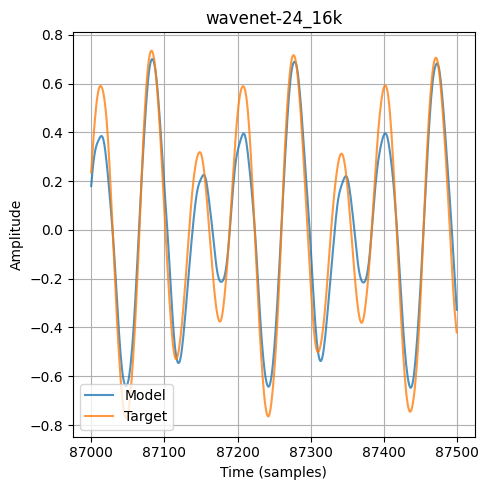

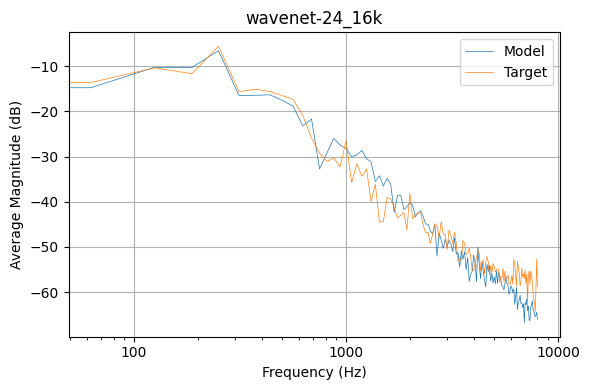

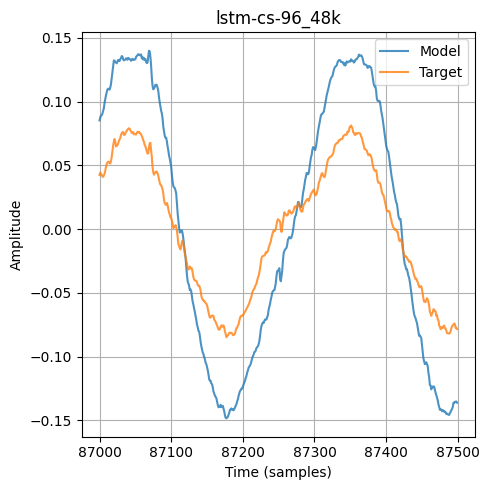

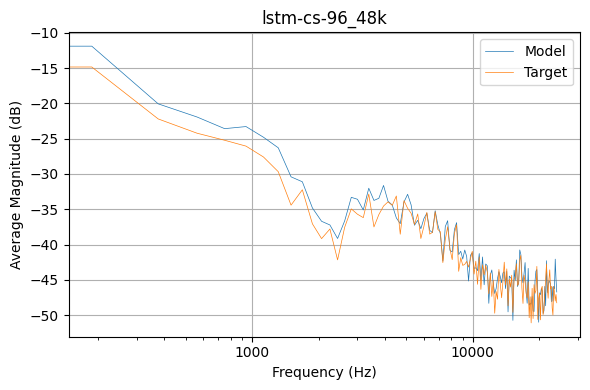

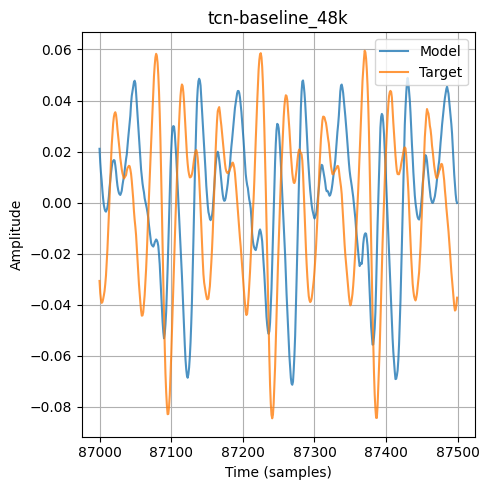

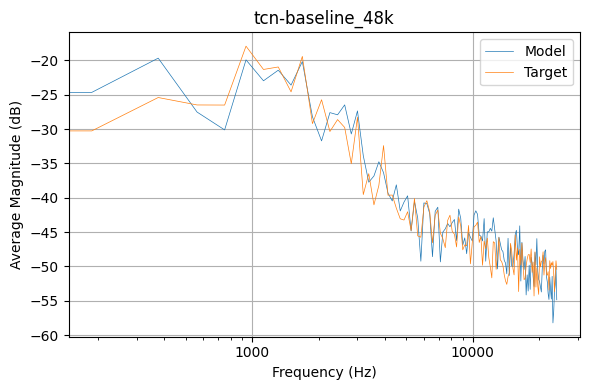

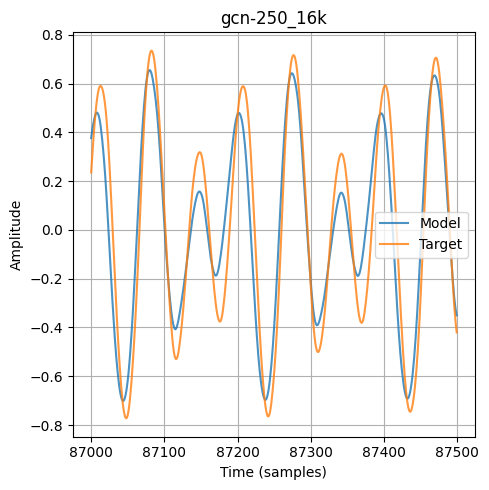

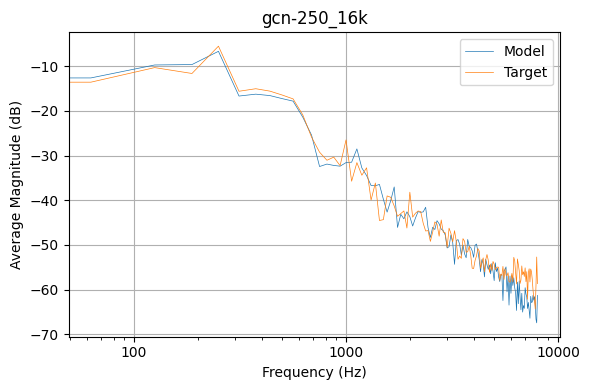

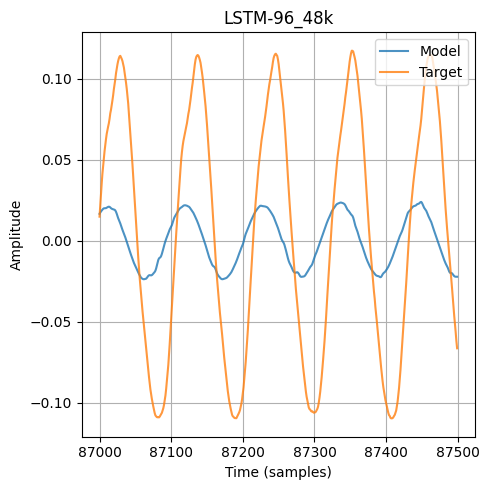

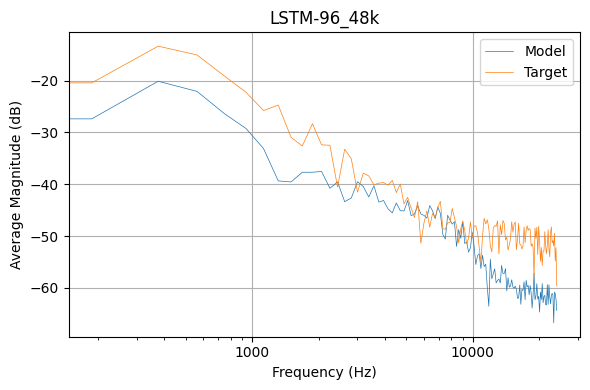

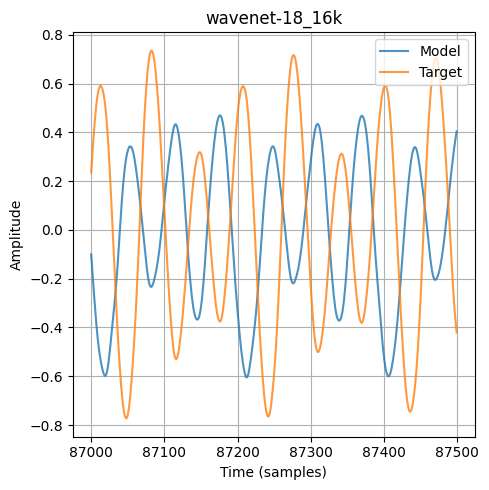

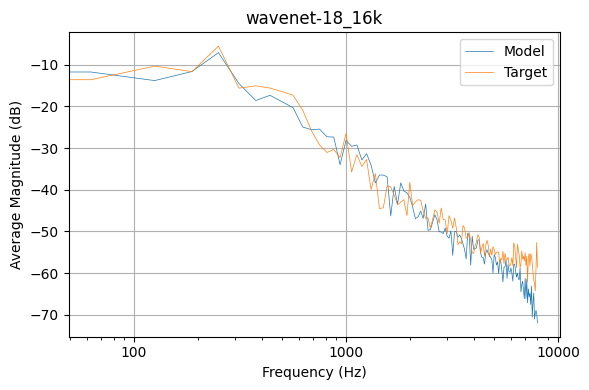

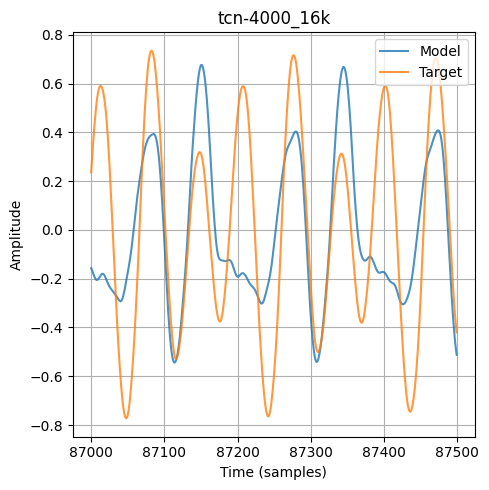

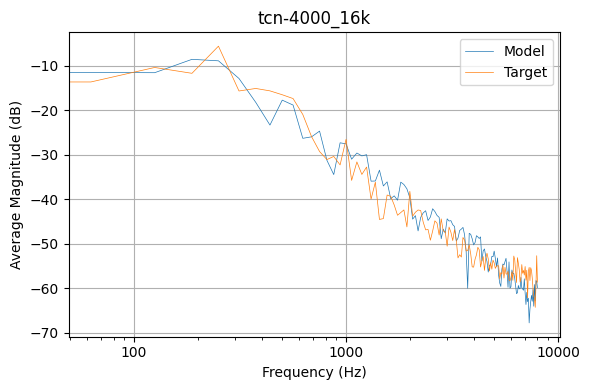

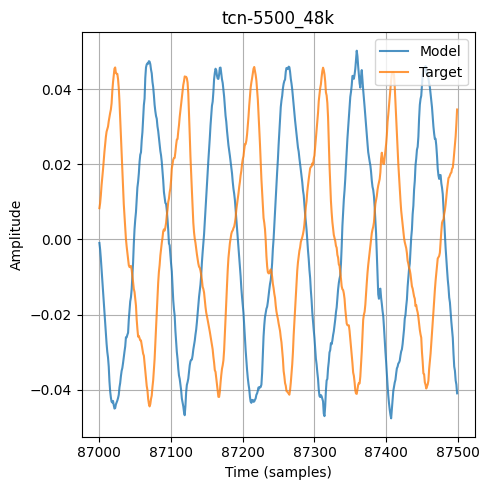

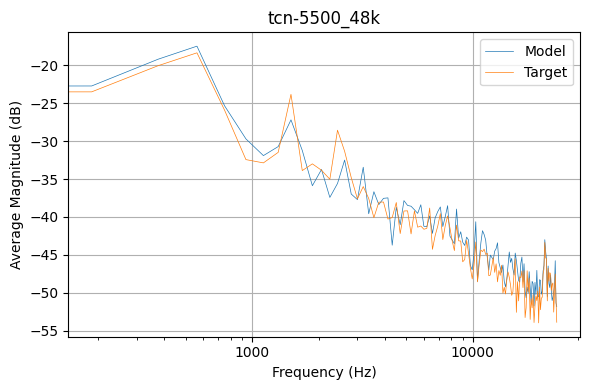

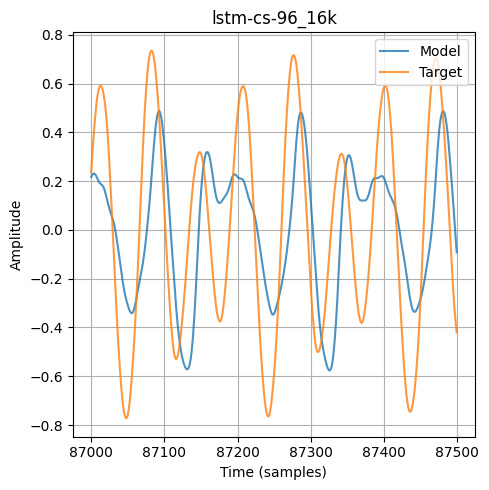

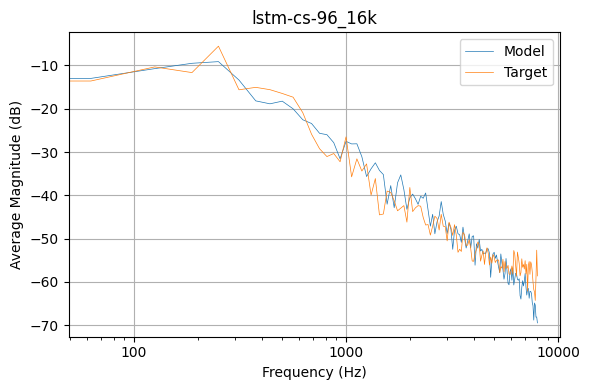

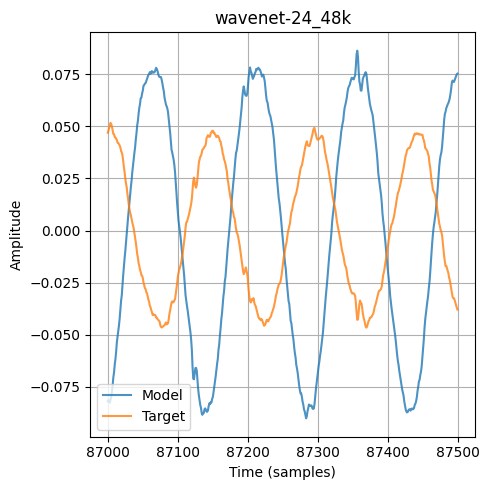

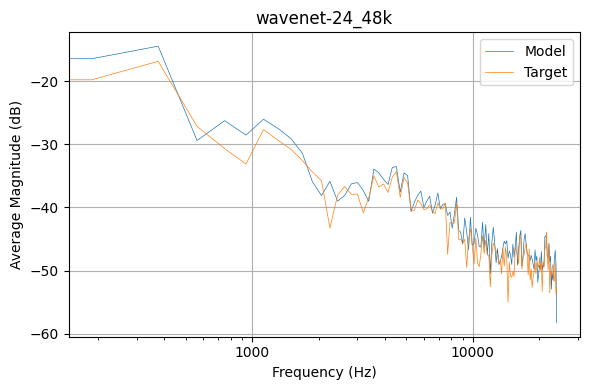

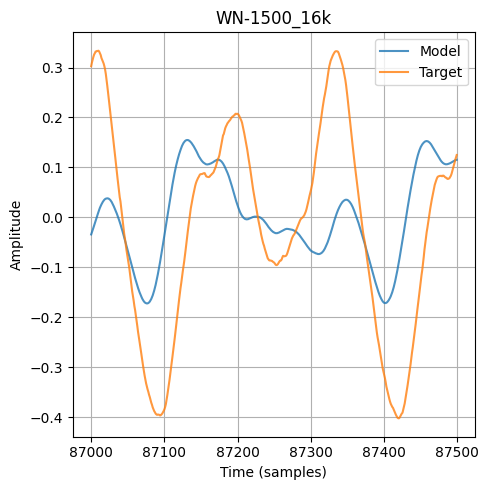

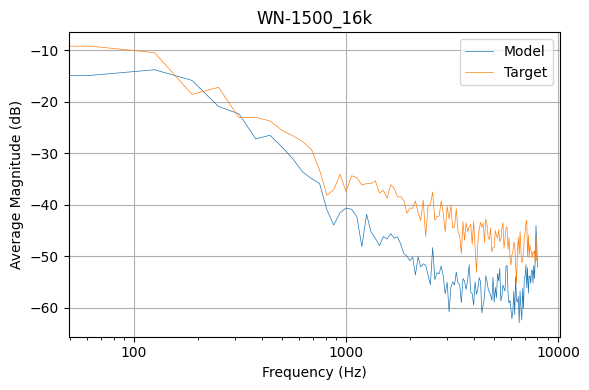

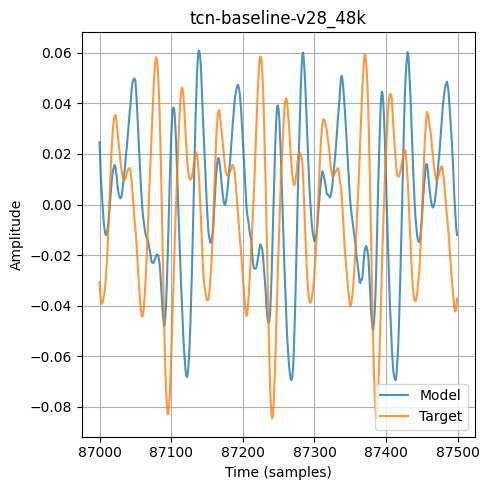

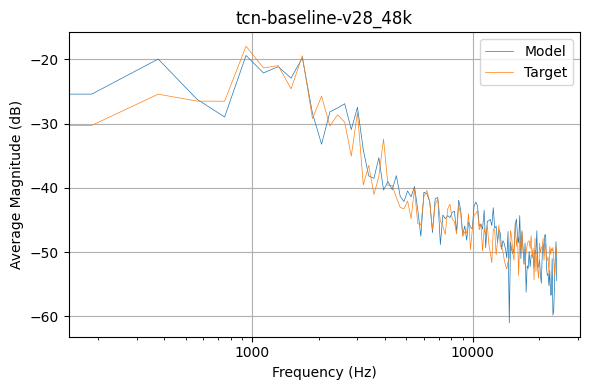

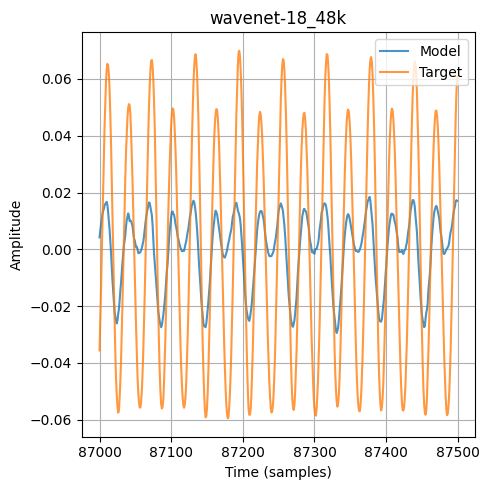

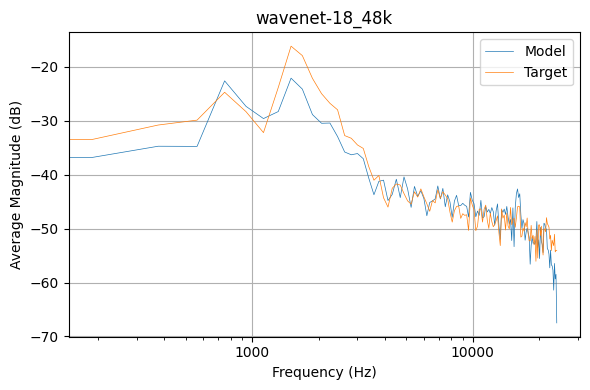

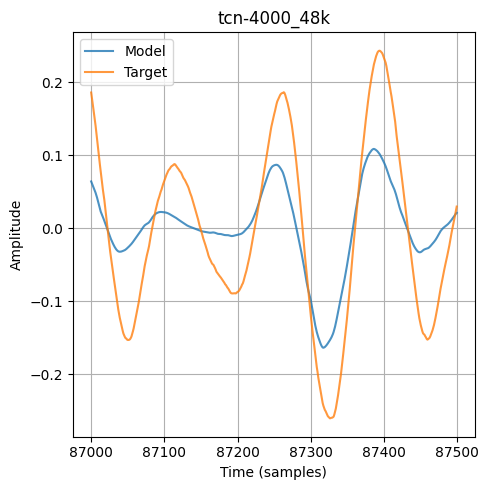

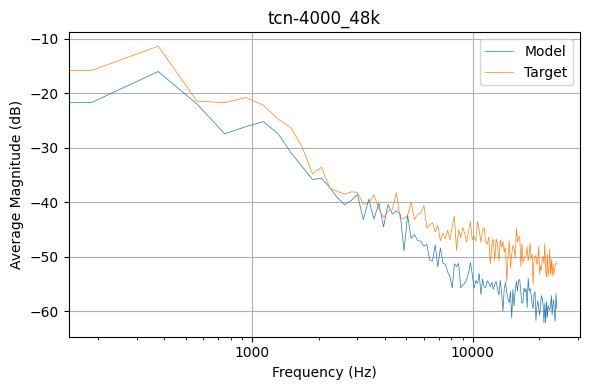

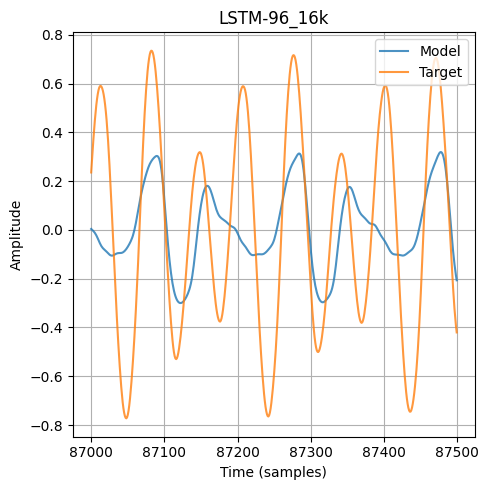

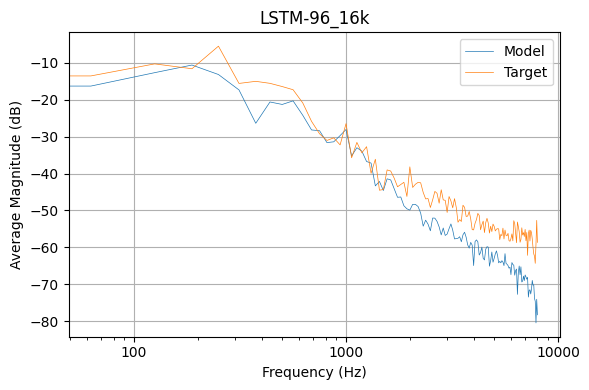

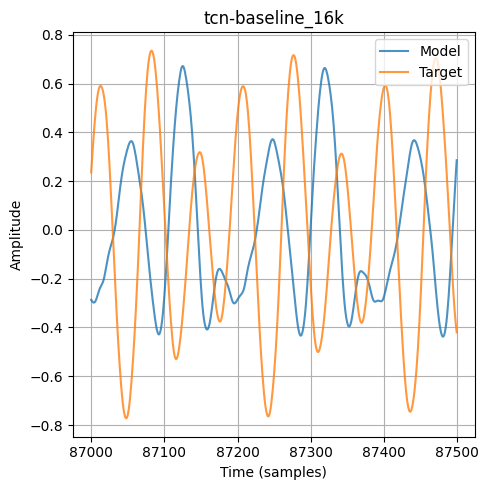

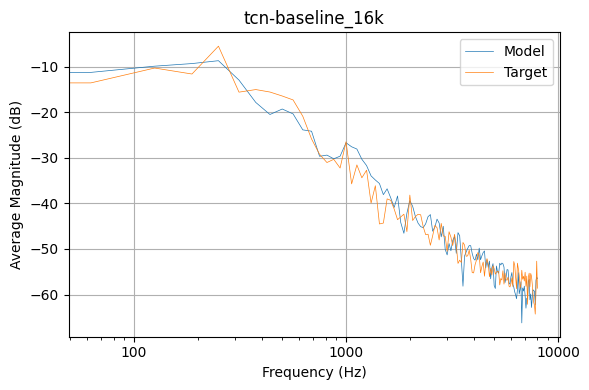

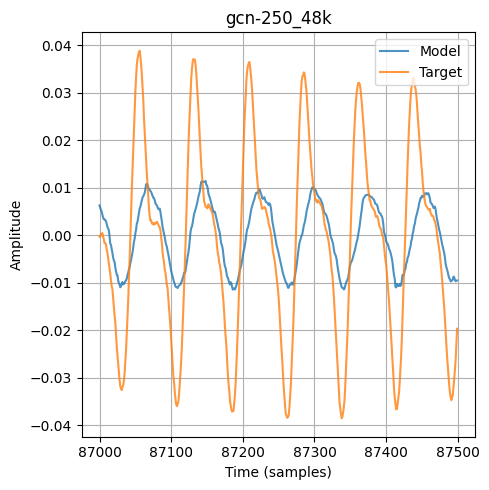

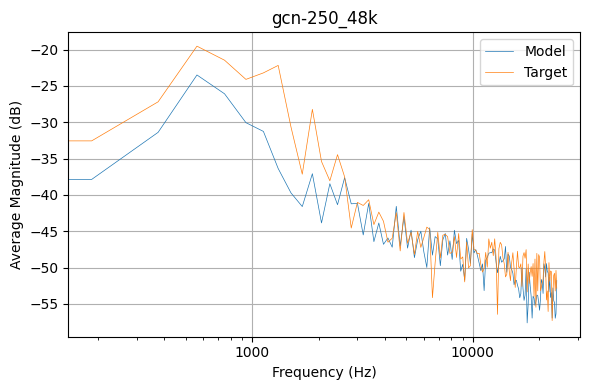

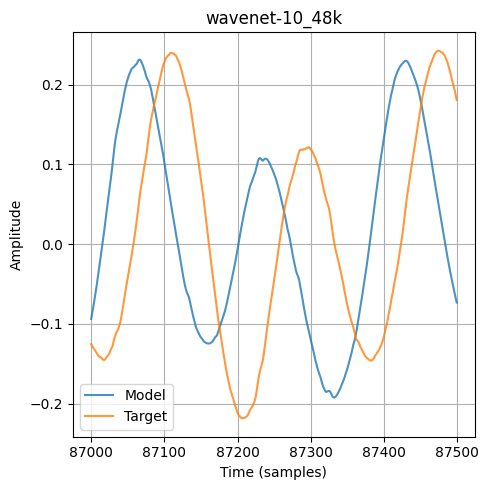

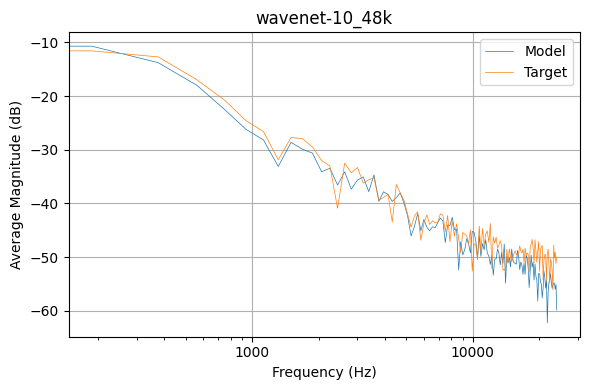

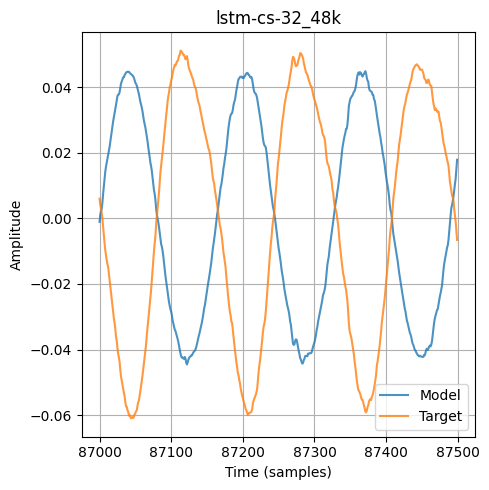

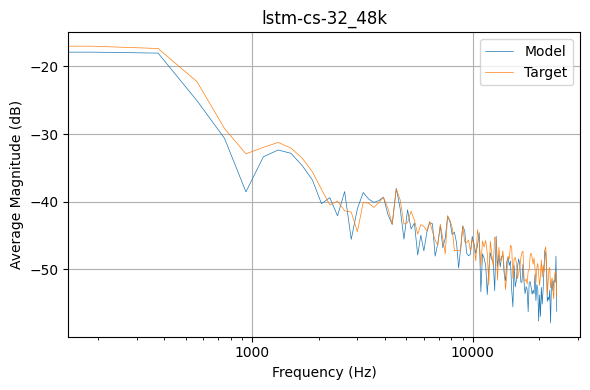

In [21]:
# Test
SAMPLES_DIR = "results/audio_batches"

start_time = 87000
end_time =  87500

process_directory(SAMPLES_DIR, start_time, end_time)